# Propensity Score Matching (PSM)

## Healthcare treatment on recovery time

We will generate synthetic data to demonstrate how PSM can effectively address confounding. The dataset includes 1,500 patients with varying ages and health scores. On average, patients are about 60 years old with a health score around 50 (higher is better). 

The medical treatment is designed to shorten recovery time, which is influenced by age (older patients recover more slowly), health score (healthier patients recover faster), and some random variation to reflect real-life conditions. 

However, medical treatments often cannot be randomly assigned. In this scenario, younger and healthier patients are more likely to receive treatment, introducing confounding because age and health also affect recovery.

In [32]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")


# Set seed for reproducibility
np.random.seed(42)

# Synthetic healthcare dataset
n = 1500
age = np.random.normal(60, 12, n)              # patient age
health_score = np.random.normal(50, 15, n)     # baseline health: higher is healthier

# Adjusted treatment assignment to increase treated group size
logit = 1.5 + 0.05 * health_score - 0.03 * age  # increased intercept
true_ps = 1 / (1 + np.exp(-logit))
treatment = np.random.binomial(1, true_ps, size=n)

# Outcome: recovery time (smaller = better)
true_effect = -5.0  # ATE (average effect of treatment)
recovery_time = (
    30
    + true_effect * treatment
    + 0.2 * age
    - 0.3 * health_score
    + np.random.normal(0, 5, n)
)

data = pd.DataFrame({
    "age": age,
    "health_score": health_score,
    "treatment": treatment,
    "recovery_time": recovery_time
})
data.groupby('treatment')['recovery_time'].agg(['count','median','mean'])

,count,median,mean
treatment,,,
0,191,30.347001,30.432970
1,1309,21.409137,21.350527


### DAG

Text(0.5, 1.0, 'Causal DAG for Synthetic Healthcare Dataset')

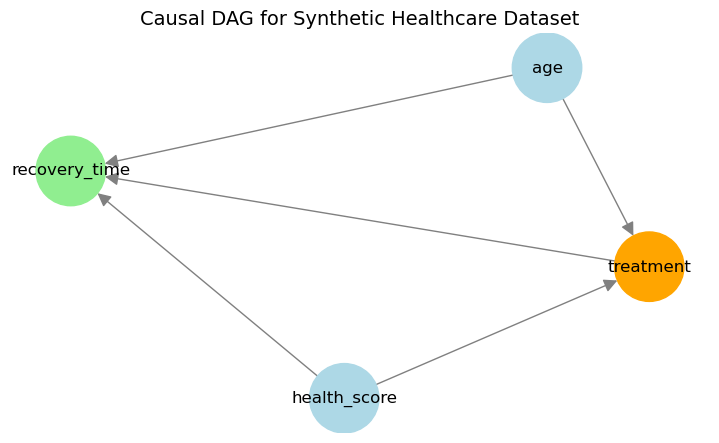

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
edges = [
    ("age", "treatment"),
    ("health_score", "treatment"),
    ("age", "recovery_time"),
    ("health_score", "recovery_time"),
    ("treatment", "recovery_time")
]

G.add_edges_from(edges)

# Define node colors
node_colors = {
    "age": "lightblue",
    "health_score": "lightblue",
    "treatment": "orange",
    "recovery_time": "lightgreen"
}

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(7, 4))
nx.draw(
    G, pos, with_labels=True,
    node_color=[node_colors[node] for node in G.nodes()],
    node_size=2500, arrowsize=20, edge_color='gray'
)
plt.title("Causal DAG for Synthetic Healthcare Dataset", fontsize=14)

In [34]:
# Naive difference in means
treated = data[data.treatment == 1]
control = data[data.treatment == 0]
naive_diff = treated["recovery_time"].mean() - control["recovery_time"].mean()
naive_diff

In [35]:
# 1. Define treatment and outcome
treatment = "treatment"
outcome = "recovery_time"
common_causes=["age", "health_score"]

# 2. Create causal model
model = CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcome,
    common_causes=common_causes
)

# 3. Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# 4.1 Estimate ATE (Average Treatment Effect)
ate_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate",
    confidence_intervals=True
)

# Print ATE and its 95% confidence interval
print("Estimated ATE:", ate_estimate.value)
print("95% Confidence Interval:", ate_estimate.get_confidence_intervals())

Estimated ATE: -5.449665265997561
95% Confidence Interval: (-6.336998455344925, -4.367804251019782)


In [36]:
# 4.2 Estimate ATT (Average Treatment Effect on Treated)
att_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att",
    confidence_intervals=True
)
print("Estimated ATT:", att_estimate.value)
print("95% Confidence Interval (ATT):", att_estimate.get_confidence_intervals())

# 4.3 Estimate CATE (Conditional Average Treatment Effect)
# For CATE, we can condition on a subset, e.g., age > 50
subset_data = data[data["age"] > 50]
cate_model = CausalModel(
    data=subset_data,
    treatment=treatment,
    outcome=outcome,
    confidence_intervals=True,
    common_causes=common_causes
)
cate_estimand = cate_model.identify_effect(proceed_when_unidentifiable=True)
cate_estimate = cate_model.estimate_effect(
    cate_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate",
    confidence_intervals=True
)
print("Estimated CATE (age > 50):", cate_estimate.value)
print("95% Confidence Interval (CATE):", cate_estimate.get_confidence_intervals())

Estimated ATT: -5.496563913967372
95% Confidence Interval (ATT): (-6.500212697731007, -4.219743716873146)
Estimated CATE (age > 50): -5.553055715447799
95% Confidence Interval (CATE): (-6.8005478976443525, -4.534868927077349)


In [38]:
# Output summaries
print("\nSummary ATE:")
print(ate_estimate)
print("\nSummary ATT:")
print(att_estimate)
print("\nSummary CATE:")
print(cate_estimate)


Summary ATE:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                         
────────────(E[recovery_time|age,health_score])
d[treatment]                                   
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→recovery_time then P(recovery_time|treatment,age,health_score,U) = P(recovery_time|treatment,age,health_score)

## Realized estimand
b: recovery_time~treatment+age+health_score
Target units: ate

## Estimate
Mean value: -5.449665265997561
95.0% confidence interval: (-6.336998455344925, -4.367804251019782)


Summary ATT:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                         
────────────(E[recovery_time|age,health_score])
d[treatment]                                  

In [39]:
# 5. Refutation tests for robustness
ref_placebo = model.refute_estimate(identified_estimand, ate_estimate, method_name="placebo_treatment_refuter")
print("\nPlacebo Test:", ref_placebo)

ref_subset = model.refute_estimate(identified_estimand, ate_estimate, method_name="data_subset_refuter")
print("\nSubset Test:", ref_subset)

ref_boot = model.refute_estimate(identified_estimand, ate_estimate, method_name="bootstrap_refuter")
print("\nBootstrap Test:", ref_boot)


Placebo Test: Refute: Use a Placebo Treatment
Estimated effect:-5.449665265997561
New effect:0.025266567006895124
p value:0.98


Subset Test: Refute: Use a subset of data
Estimated effect:-5.449665265997561
New effect:-5.444651763762675
p value:0.98


Bootstrap Test: Refute: Bootstrap Sample Dataset
Estimated effect:-5.449665265997561
New effect:-5.563997498052214
p value:0.84



### Manual matching
DoWhy’s current version does not return matched_indices or matched_data by default in the CausalEstimate object. Unlike some other libraries, DoWhy’s PSM only uses the matched data internally to compute the effect, and it doesn’t expose it.

Some libraries like EconML or causalml have PSM functions that return the matched dataset directly, making plotting easier.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
# Manual propensity score matching (nearest neighbor)
X = data[["age", "health_score"]]
y = data["treatment"]

# 1. Logistic regression to estimate PS
ps_model = LogisticRegression()
ps_model.fit(X, y)
propensity_scores = ps_model.predict_proba(X)[:, 1]
data["ps"] = propensity_scores

# 2. Match treated to nearest control by PS
treated_idx = data[data.treatment == 1].index
control_idx = data[data.treatment == 0].index

nn = NearestNeighbors(n_neighbors=1)
nn.fit(data.loc[control_idx, ["ps"]])
_, indices = nn.kneighbors(data.loc[treated_idx, ["ps"]])

matched_controls = control_idx[indices.flatten()]
matched_data = pd.concat([data.loc[treated_idx], data.loc[matched_controls]])

# 3. Simple difference-in-means
manual_psm_diff = (
    matched_data[matched_data.treatment == 1]["recovery_time"].mean()
    - matched_data[matched_data.treatment == 0]["recovery_time"].mean()
)
manual_psm_diff

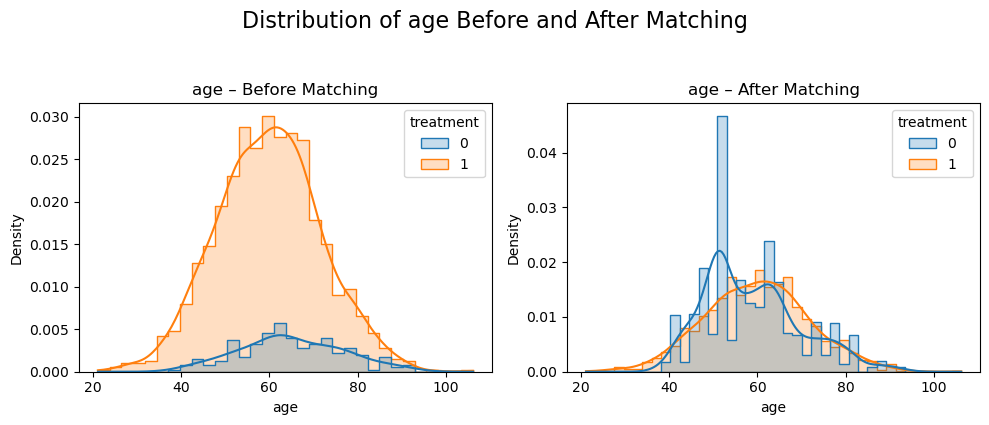

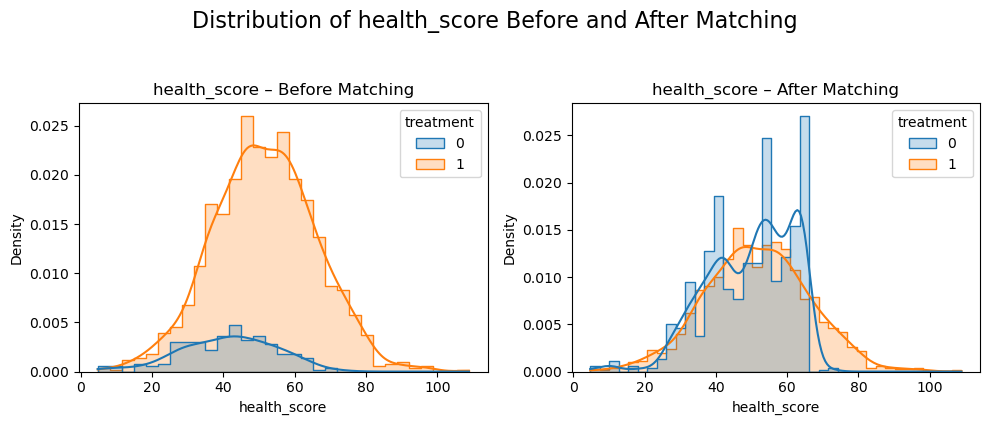

In [22]:
# 4.1: Diagnostics (Distributions)
# Plots the distribution of a single covariate before and after matching.
def plot_it(variable):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Before Matching
    sns.histplot(data=data, x=variable, hue='treatment',  stat='density',kde=True,
                 element='step', ax=axes[0])
    axes[0].set_title(f"{variable} – Before Matching")
    axes[0].set_xlabel(variable)
    axes[0].set_ylabel("Density")
    # After Matching
    sns.histplot(data=matched_data, x=variable, hue='treatment',  stat='density', kde=True,
                 element='step', ax=axes[1])
    axes[1].set_title(f"{variable} – After Matching")
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel("Density")

    fig.suptitle(f"Distribution of {variable} Before and After Matching", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# 1) Distribution Plots: Before / After per Variable
for i in common_causes:
    plot_it(i)

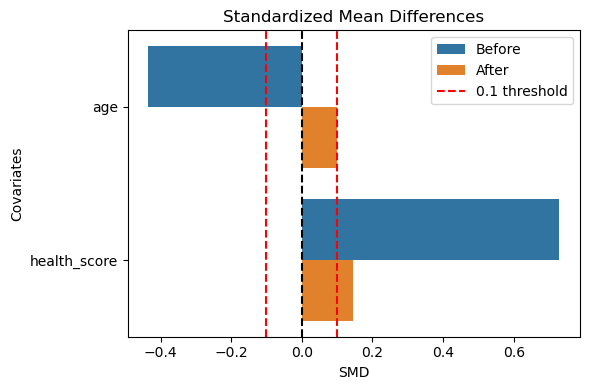

In [23]:
# 4.2: Diagnostics (Standardized Mean Differences)
def smd(df, treat_col, covariate):
    treated_group = df[df[treat_col]==1][covariate]
    control_group = df[df[treat_col]==0][covariate]
    return (treated_group.mean() - control_group.mean()) / np.sqrt((treated_group.var() + control_group.var())/2)

before_smd = [smd(data, 'treatment', c) for c in common_causes]
after_smd = [smd(matched_data, 'treatment', c) for c in common_causes]

smd_df = pd.DataFrame({
    'Covariate': common_causes,
    'Before': before_smd,
    'After': after_smd
}).melt(id_vars='Covariate', var_name='Stage', value_name='SMD')

# Create a single horizontal barplot
plt.figure(figsize=(6, 4))
sns.barplot(data=smd_df, x='SMD', y='Covariate', hue='Stage')
plt.axvline(0, color='black', linestyle='--')
plt.axvline(0.1, color='red', linestyle='--', label='0.1 threshold')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title('Standardized Mean Differences')
plt.xlabel('SMD')
plt.ylabel('Covariates')
plt.legend()
plt.tight_layout()
plt.show()


## Paper - LaLonde (1986)
- Robert J. LaLonde (1986). Evaluating the Econometric Evaluations of Training Programs. American Economic Review, Vol. 76, No. 4, pp. 604–620. Published by the American Economic Association.
Access via JSTOR or EconPapers entry.
- Data: https://users.nber.org/~rdehejia/data/.nswdata2.html?utm_source=chatgpt.com

### Experimental data

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from dowhy import CausalModel

# Load datasets
path = '/Users/chriskuo/Documents/My_documents_all/Book_causal_inference/data/'
nsw = pd.read_stata(path + "nsw.dta")  # Experimental benchmark

# Compute experimental benchmark using simple mean difference
ate_exp_simple = nsw[nsw["treat"] == 1]["re78"].mean() - nsw[nsw["treat"] == 0]["re78"].mean()
print("Experimental ATE (simple mean difference):", ate_exp_simple)
nsw.groupby('treat')['re78'].agg(['count','median','mean'])

Experimental ATE (simple mean difference): 886.3037


,count,median,mean
treat,,,
0,425,3746.700928,5090.048340
1,297,4232.309082,5976.352051


### Observational Data

In [42]:
psid_controls = pd.read_stata(path + "psid_controls3.dta")           # Observational sample
# Combine NSW treated units with PSID controls for observational analysis
nsw_treated = nsw[nsw["treat"] == 1]

data = pd.concat([nsw_treated, psid_controls], ignore_index=True)
data.groupby('treat')['re78'].agg(['count','median','mean'])

,count,median,mean
treat,,,
0.0,128,0.000000,5279.293457
1.0,297,4232.309082,5976.352051


### LaLonde DAG

Text(0.5, 1.0, "DAG for LaLonde's Dataset")

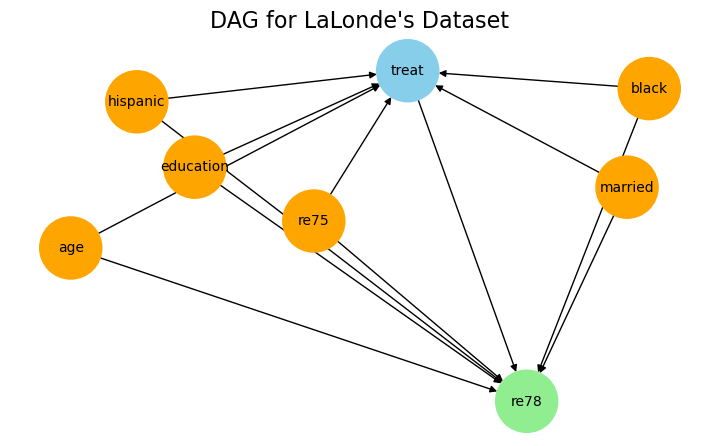

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

# Define nodes
treatment = "treat"
outcome = "re78"
confounders = ["age", "education", "black", "hispanic", "married", "re75"] # "nodegree",

# Create a directed graph
G = nx.DiGraph()

# Add nodes with color attributes
treatment_color = "skyblue"
outcome_color = "lightgreen"
confounder_color = "orange"

G.add_node(treatment, color=treatment_color)
G.add_node(outcome, color=outcome_color)
for conf in confounders:
    G.add_node(conf, color=confounder_color)

# Add edges from confounders to treatment and outcome
for conf in confounders:
    G.add_edge(conf, treatment)
    G.add_edge(conf, outcome)

# Add edge from treatment to outcome
G.add_edge(treatment, outcome)

# Get node colors
colors = [G.nodes[node]['color'] for node in G.nodes]

# Draw the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(7, 4))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, font_size=10, arrows=True)
plt.title("DAG for LaLonde's Dataset", fontsize=16)

### LaLonde - DoWhy 

In [44]:
data = pd.concat([nsw_treated, psid_controls], ignore_index=True)
data['treat'].value_counts()

treat
1.0    297
0.0    128
Name: count, dtype: int64

In [47]:
# 1. Define treatment and outcome
treatment = "treat"
outcome = "re78"

# 2. Create causal model
model = CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcome,
    common_causes=["age", "education", "black", "hispanic", "married", "nodegree", "re75"]
)

# 3. Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# 4.1 Estimate ATE (Average Treatment Effect)
ate_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate",
    confidence_intervals=True
)
print("Estimated ATE:", ate_estimate.value)
print("95% Confidence Interval (ATE):", ate_estimate.get_confidence_intervals())

# 4.2 Estimate ATT (Average Treatment effect on Treated)
att_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att",
    confidence_intervals=True
)
print("Estimated ATT:", att_estimate.value)
print("95% Confidence Interval (ATT):", att_estimate.get_confidence_intervals())

# 4.3 Estimate CATE (Conditional Average Treatment Effect)
# For CATE, we can condition on a subset, e.g., age > 20
subset_data = data[data["education"] > 8]
cate_model = CausalModel(
    data=subset_data,
    treatment=treatment,
    outcome=outcome,
    common_causes=["age", "education", "black", "hispanic", "married", "nodegree", "re75"]
)
cate_estimand = cate_model.identify_effect(proceed_when_unidentifiable=True)
cate_estimate = cate_model.estimate_effect(
    cate_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate",
    confidence_intervals=True
)
print("Estimated CATE (education > 8):", cate_estimate.value)
print("95% Confidence Interval (CATE):", cate_estimate.get_confidence_intervals())

Estimated ATE: 1704.2661075367646
95% Confidence Interval (ATE): (-328.89556457519575, 4561.242230224609)
Estimated ATT: 915.2728520146122
95% Confidence Interval (ATT): (-1168.5318174468746, 5144.002276729017)
Estimated CATE (education > 8): 940.1683904316351
95% Confidence Interval (CATE): (-1145.1340057286102, 3937.425067825535)


### LaLonde - Manual matching
We will do:
1. Logistic regression
2. Nearest neighbor or caliper matching
3. Simple difference-in-means
4. Diagnostics: Distribution, Standardized Mean Differences

**Steps 1, 2:**

In [50]:
from sklearn.linear_model import LogisticRegression

confounders = ["age", "education", "black", "hispanic", "married", "nodegree", "re75"]

# Fit logistic regression for propensity scores
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(data[confounders], data['treat'])
data['propensity_score'] = ps_model.predict_proba(data[confounders])[:,1]

# Separate treated and control
treated = data[data['treat'] == 1].copy()
control = data[data['treat'] == 0].copy()

# For each treated unit, find nearest control by propensity score
matched_indices = []
for i, row in treated.iterrows():
    # Find control with minimum propensity score distance
    idx = (np.abs(control['propensity_score'] - row['propensity_score'])).idxmin()
    matched_indices.append(idx)

matched_control = control.loc[matched_indices].copy()
matched_treated = treated.copy()

# Combine matched treated and control
matched_data = pd.concat([matched_treated, matched_control])

**Step 3:**

In [51]:
ate_matched_data = matched_data[matched_data["treat"] == 1]["re78"].mean() - matched_data[matched_data["treat"] == 0]["re78"].mean()
print("Experimental ATE (simple mean difference):", ate_matched_data)
matched_data.groupby('treat')['re78'].agg(['count','median','mean'])

Experimental ATE (simple mean difference): 915.27295


,count,median,mean
treat,,,
0.0,297,1152.626709,5061.079102
1.0,297,4232.309082,5976.352051


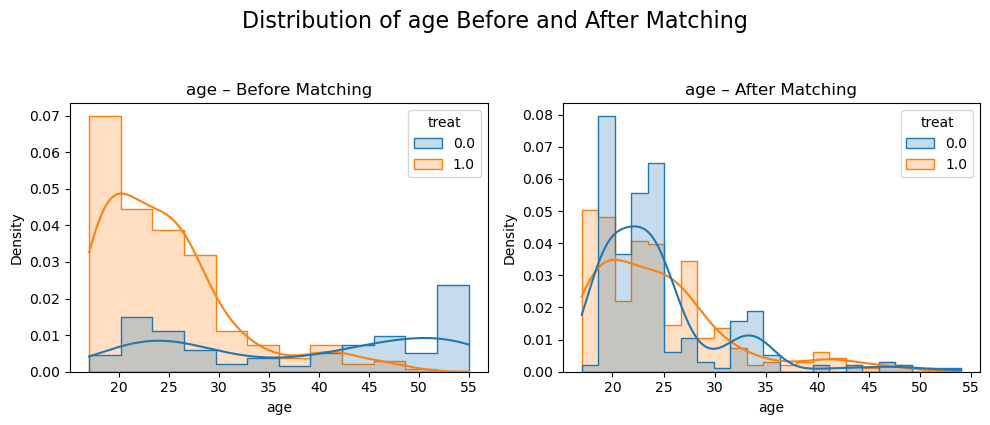

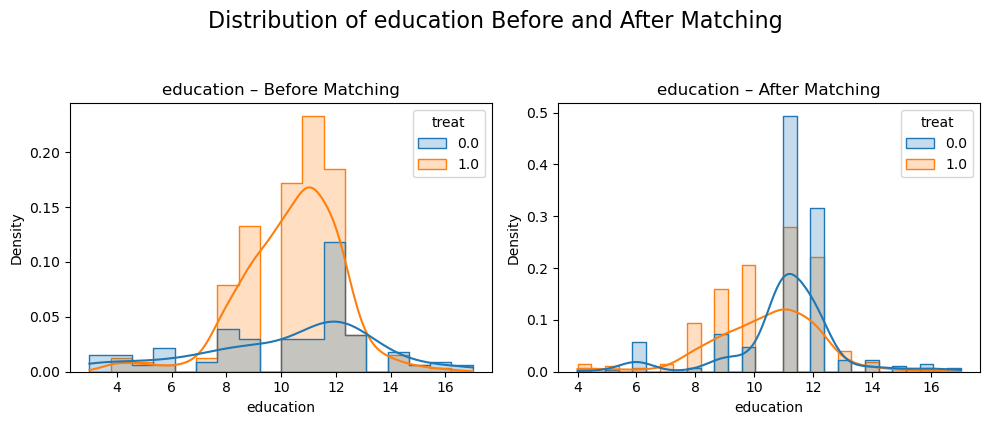

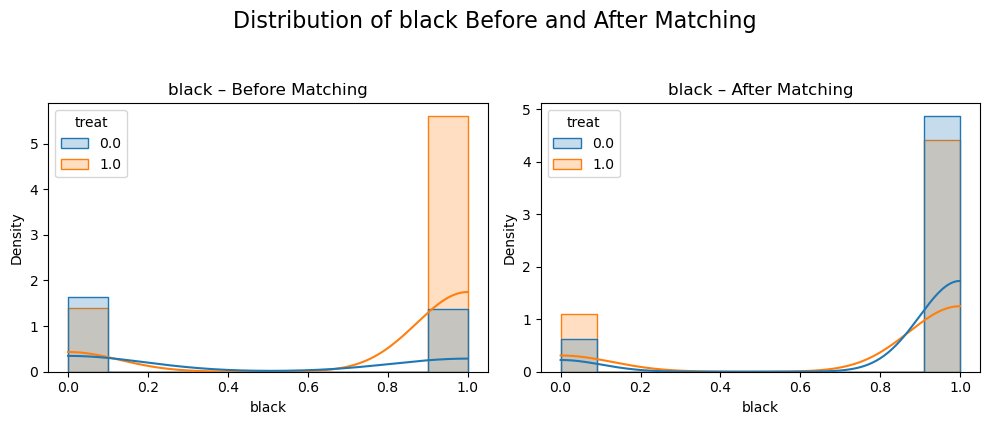

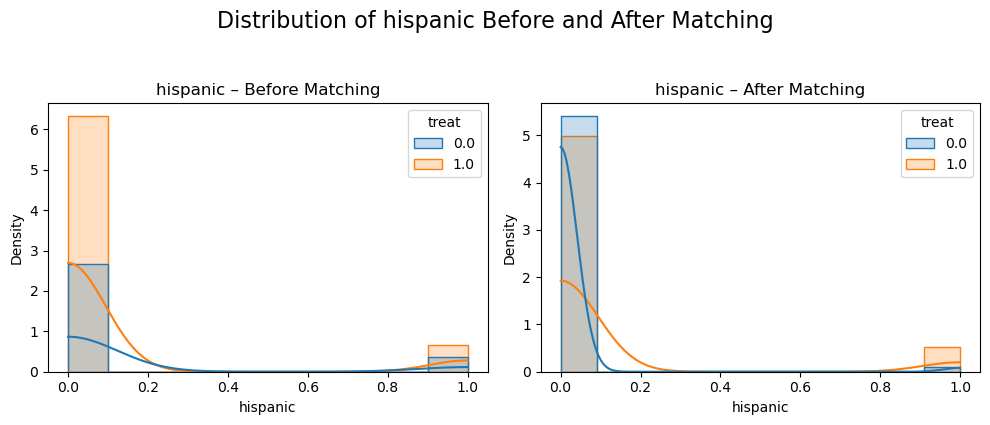

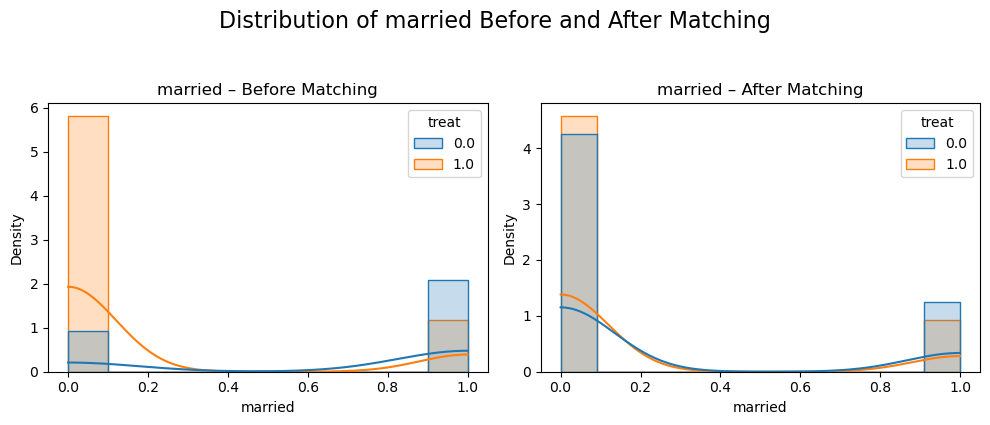

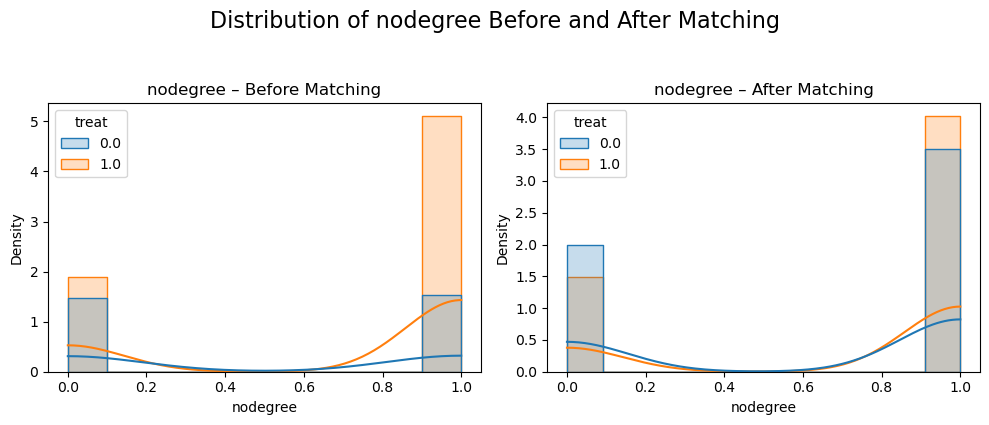

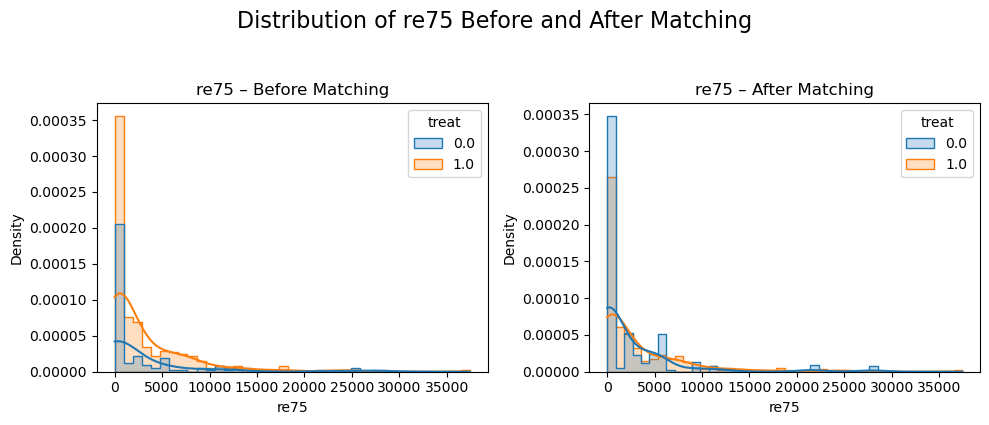

In [412]:
# Plots the distribution of a single covariate before and after matching.
def plot_it(variable):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Before Matching
    sns.histplot(data=data, x=variable, hue='treat',  stat='density',kde=True,
                 element='step', ax=axes[0])
    axes[0].set_title(f"{variable} – Before Matching")
    axes[0].set_xlabel(variable)
    axes[0].set_ylabel("Density")
    # After Matching
    sns.histplot(data=matched_data, x=variable, hue='treat',  stat='density', kde=True,
                 element='step', ax=axes[1])
    axes[1].set_title(f"{variable} – After Matching")
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel("Density")

    fig.suptitle(f"Distribution of {variable} Before and After Matching", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# 1) Distribution Plots: Before / After per Variable
for i in confounders:
    plot_it(i)

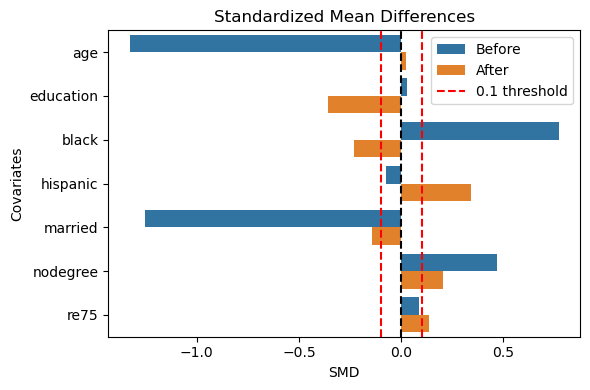

In [413]:
# Standardized Mean Differences
def smd(df, treat_col, covariate):
    treated_group = df[df[treat_col]==1][covariate]
    control_group = df[df[treat_col]==0][covariate]
    return (treated_group.mean() - control_group.mean()) / np.sqrt((treated_group.var() + control_group.var())/2)

before_smd = [smd(data, 'treat', c) for c in confounders]
after_smd = [smd(matched_data, 'treat', c) for c in confounders]

smd_df = pd.DataFrame({
    'Covariate': confounders,
    'Before': before_smd,
    'After': after_smd
}).melt(id_vars='Covariate', var_name='Stage', value_name='SMD')

# Create a single horizontal barplot
plt.figure(figsize=(6, 4))
sns.barplot(data=smd_df, x='SMD', y='Covariate', hue='Stage')
plt.axvline(0, color='black', linestyle='--')
plt.axvline(0.1, color='red', linestyle='--', label='0.1 threshold')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title('Standardized Mean Differences')
plt.xlabel('SMD')
plt.ylabel('Covariates')
plt.legend()
plt.tight_layout()
plt.show()

,count,median,mean
treat,,,
0.0,297,1152.626709,5061.079102
1.0,297,4232.309082,5976.352051


Experimental ATE (simple mean difference): 915.27295
